In [1]:
import numpy as np
import matplotlib.pyplot as plt

#dimensions
DIM=3

#indexing constants
U=1; L=0
X=0; Y=1; Z=2

#electron
qElectron=-1.6e-16
mElectron=9.109e-31

#unit vectors
xhat = np.array([1,0,0])
yhat = np.array([0,1,0])
zhat = np.array([0,0,1])

sign = [-1, 1]
label = ['x','y','z']

eps0=8.85e-12

class Capacitor:
    def __init__(self, separation, initialCharge, location=np.zeros(DIM), xlength=1, ylength=1, Nx=100, Ny=100, 
                 Nsteps=10, dx=0,dy=0, dielectricConstant=1):
        '''
        separation = distance between upper  and lower plates.
        initialCharge = charge initially assigned to upper plate (-1*initialCharge assigned to lower plate)
        location = location of corner of capacitor with min x,y, and z values
        xlength = plate length along x axis
        ylength = plate length along y axis
        Nx = number of rows plate is divided into (for summing electric fields due to charge density)
        Ny = number of columns plate is divided into
        dx = row width. If specified, then Nx is disregarded and self.Nx = xlength/dx.
        dy = column width. If specified, then Ny is disregarded.
        Nsteps = number of timesteps particle is given to travel between plates (roughly) for voltage calculation.
        '''
        self.eps=eps0*dielectricConstant
        
        Max=np.zeros(DIM)
        Max[X]=location[X]+xlength; Max[Y]=location[Y]+ylength; Max[Z] = location[Z]+separation
        
        
        N=[0,0,0] #N = [plate rows, plate columns, number of plates], relevant to x,y,z axes
        if (dx):
            self.dx=dx
            N[X]=int(xlength/dx)
        else:
            self.dx=xlength/Nx
            N[X]=Nx
            
        if (dy):
            self.dy=dy
            N[Y]=int(ylength/dy)
        else:
            self.dy=ylength/Ny
            N[Y]=Ny
            
        N[Z]=2 #number of plates
        self.N = N
        
        self.Nsteps=Nsteps
        
        #minimum and maximum coordinates of capacitor
        self.Min=location
        self.Max=Max
        
        self.dims=separation
        self.zP = [0, separation] 
        
        self.Q=initialCharge
        
        #Theoretical capacitance for comparison
        self.C = Max[X]*Max[Y]*self.eps / separation
        self.v = self.CalculateVoltageDrop()
        self.dr=np.array([self.dx,self.dy])
        
 
   
        
        
    def Timestep(self,dt, Nsteps=-1):
        '''
        Adjust stored charge based on current and calculate new voltage
        '''
        if Nsteps==-1:
            Nsteps=self.Nsteps
        #define conventional current to flow from upper plate to lower plate
        dq = self.i*dt
        self.Q += dq
        self.v = self.CalculateVoltageDrop(Nsteps=Nsteps)
        
        
    def GetXY(self,coord,loc,zdash):
        '''
        Returns 1D array corresponding to 'coord' axis (x or y). 
        loc = position at which electric field is measured
        zdash: specifies whether we are measuring the field of the top or bottom plate
        '''
        N=self.N[coord]
        Min=self.Min; Max=self.Max
        d = np.abs(zdash-loc[Z]) #distance to plate
        
        # angles corresponding to either edge of plate 
        theta0 = np.arctan((Min[coord] - loc[coord]) / d)
        thetaf = np.arctan((Max[coord] - loc[coord]) / d)
        
        dtheta = (thetaf - theta0) / (N+1)
        
        coord_array=np.array([loc[coord] + d * np.tan(theta) for theta in np.linspace(theta0, thetaf, N+1)])
        return coord_array
    
    
    def GetZ(self,k):
        Min=self.Min; Max=self.Max
        return Min[Z] + k * (Max-Min)[Z]
    
    
    def ElectricField(self,loc):
        '''
        Returns electric field at location specified by loc.
        '''
        r=loc
        area = (self.Max[X]-self.Min[X]) * (self.Max[Y]-self.Min[Y])
        sigma = self.Q/area
        E = np.zeros(3)
        N=self.N
        # arrays of x and y values whose charges will contribute to field
        for k in range (N[Z]):
            zdash = self.GetZ(k)
            X_arr = self.GetXY(X,loc,zdash)
            Y_arr = self.GetXY(Y,loc,zdash)
            
            for i in range (N[X]):
                xdash=(X_arr[i] + X_arr[i+1])/2
                dx = X_arr[i+1]-X_arr[i]
                
                for j in range(N[Y]):
                    ydash=(Y_arr[j] + Y_arr[j+1])/2
                    dy = Y_arr[j+1]-Y_arr[j]
                    
                    dq = sigma*sign[k]*dx*dy
                    rdash = np.array([xdash,ydash,zdash])
                    dE= ((1/(4*np.pi*self.eps)) * dq / (np.dot((r-rdash),(r-rdash))**(3/2))) * (r-rdash)
                    E+=dE
        return E
       
        
    def ElectricFieldTheoretical(self,loc):
        '''
        returns electric field for ideal capacitor.
        '''
        Max=self.Max; Min=self.Min
        A = (Max[X]-Min[X])*(Max[Y]-Min[Y])
        sigma = self.Q / A
        x,y,z=loc
        if (Min[X]<x and x<Max[X] and Min[Y]<y and y<Max[Y] and Min[Z]<z and z<Max[Z]):
            return np.array([0,0,-sigma/self.eps])
        return np.zeros(3)
    
    
    def CalculateEnergyGain(self, mingap, Nsteps=10, m=1, q=1):
        '''
        Measures the kinetic energy gained by a charged particle passing between the plates
        mingap = distance below upper plate particle is released, and how close particle
            must be to lower plate before energy is measured.
        Nsteps = number of timesteps we want to allow, and is used to calculate an appropriate dt
        '''
        Max=self.Max; Min=self.Min
        d=Max[Z]-Min[Z]
        center=(Max+Min)/2
        #place charged particle a fraction below the center of the upper, positively charged plate
        r = np.array([center[X], center[Y], Max[Z]-mingap])
        v=np.zeros(3)
        a=np.zeros(3)
        
        
        #if there is no field, then particle cannot be accelerated and so can't gain energy
        Ez=np.dot(self.ElectricField(center),zhat)
        az=q*Ez/m
        
        #First we need to work out timestep size and initial velocity
        if az==0:
            #need to give the positron some initial velocity so that it can reach the lower plate
            v[Z]=-1000 #arbitrary for zero acceleration
            dt = (v[Z]/d)/Nsteps
        elif az<0:
            #simply release the charge and allow it to be accelerated to the bottom plate
            dt = np.sqrt(2*(-(Max-Min)[Z])/az)/Nsteps
        elif az>0:
            # Need to fire the electron downwards fast enough to reach the lower plate before it's
            # turned around by the electric field.
            vz = -5*np.sqrt(2*az*d) # 5 times the velocity needed to get us the distance
            t = (-vz - np.sqrt(vz**2 + 2*az*(-d)))/az
            dt = t/Nsteps
            v[Z]=vz
            
        else:
            print("CalculateEnergyBroken")
        Ki = (1/2)*m*np.dot(v,v)
        t=0
        n=0
        while (r[Z]>=Min[Z]+mingap and r[Z]<=Max[Z]-mingap):
            E=self.ElectricField(r)
            a = q*E/m
            v+=a*dt
            r+=v*dt
            t+=dt
            n+=1
        Kf = (1/2)*m*np.dot(v,v)
        return Kf-Ki
                    
    def CalculateVoltageDrop(self, Nsteps=-1):
        if Nsteps==-1:
            Nsteps=self.Nsteps
        #calculates voltage drop by measuring energy gained by an electron passing from upper plate to lower plate
        m=9.109e-31
        
        dKE = self.CalculateEnergyGain(mingap=(self.Max-self.Min)[Z]*1e-5, Nsteps=Nsteps, m=mElectron, q=qElectron)
        dKE_eV = dKE/qElectron #energy gain in electronvolts
        
        return dKE_eV
    
        
    def PlotElectricField(self, axis, N, plotname="", direction=np.array([0,0,0])):
        '''
        Plots Electric field vs axis specified
        
        axis = variable against which Electric field is plotted
        N = number of points to be plotted
        plotname = name of file for plot to be saved to (doesn't save if not specicfied)
        direction = the direction whose component of electric field is plotted. If
            not specified then absolute strength of E field is plotted
        '''
        
        E = np.zeros((N,3))
        Eth = np.zeros((N,3))
        Max=self.Max; Min=self.Min
        dims = Max - Min #dimensions of capacitor
        dx=self.dx; dy=self.dy
        dom = np.linspace(Min[axis]-0.5*dims[axis], Max[axis]+0.5*dims[axis],N)
        
        if (axis==X):
            for i in range(N):
                loc = np.array([dom[i], Min[Y]+dims[Y]/2, Min[Z]+dims[Z]/2])
                E[i] = self.ElectricField(loc)
                Eth[i]=self.ElectricFieldTheoretical(loc)
        elif (axis==Y):
            for j in range(N):
                loc = np.array([Min[X]+dims[X]/2], dom[j], Min[Z]+dims[Z]/2)
                E[j] = self.ElectricField(loc)
                Eth[j]=self.ElectricFieldTheoretical(loc)
        elif (axis==Z):
            for k in range(N):
                loc = np.array([Min[X]+dims[X]/2, Min[Y]+dims[Y]/2, dom[k]])
                E[k] = self.ElectricField(loc)
                Eth[k]=self.ElectricFieldTheoretical(loc)
      
        
        if (direction.any()):
            #plot E field in specified direction
            component = direction / np.sqrt(np.dot(direction,direction))
            Eplot = np.dot(E,component)
            Ethplot=np.dot(Eth,component)
            if (component == zhat).all():
                Elabel = "Electric field in z direction"
            elif (component == xhat).all():
                Elabel = "Electric field in x direction"
            elif (component == yhat).all():
                Elabel = "Electric field in y direction"
            else:
                Elabel = "Electric field in "+str(direction)+" direction"
        else:
            #plot E strength
            Eplot = np.sqrt(np.dot(E,E))
            Ethplot=np.sqrt(np.dot(Eth,Eth))
            Elabel = "Electric Field Strength"
            
        plt.figure()
        plt.xlabel(label[axis])
        plt.ylabel(Elabel)
        
        plt.plot(dom,Ethplot,'g')
        plt.plot(dom,Eplot)
            
        if (axis==Z):
            #plot capacitor plates
            axis=plt.axis()
            plt.plot(Min[Z]*np.ones(N), np.linspace(axis[2],axis[3], N), 'b')
            plt.plot(Max[Z]*np.ones(N), np.linspace(axis[2],axis[3], N),'r')
            plt.axis(axis)
        plt.tight_layout()
        if (plotname):
            plt.savefig(plotname)
            
        plt.show()
        return
            
        
    def VFPlotElectricField(self, Nx, Nz, plotname="",theoretical=False, axislimits=False):
        '''
        Creates a vector field plot of the Electric field in a cross section of the parallel plates
        (specified by y=ymax/2)
        Nx = number of arrows per row
        Nz = number of arrows per column
        axislimits = [xmin, xmax, ymin, ymax] of plot
        '''
        Max=self.Max; Min=self.Min
        E = np.zeros((Nx,Nz,2))
        Ex=np.zeros((Nx,Nz))
        Ez=np.zeros((Nx,Nz))
        if not axislimits:
            axislimits = [-0.6*Max[X], 1.6*Max[X], -0.6*Max[Z], 1.6*Max[Z]]
        x=np.linspace(axislimits[0], axislimits[1], Nx)
        y=(Max-Min)[Y]/2
        z=np.linspace(axislimits[2], axislimits[3],Nz)
        
        for i in range(Nx):
            for k in range(Nz):
                if theoretical:
                    Efield=self.ElectricFieldTheoretical(np.array([x[i], y, z[k]]))
                else:
                    Efield=self.ElectricField(np.array([x[i], y, z[k]]))
                Estr=np.sqrt(np.dot(Efield, Efield))
                #ditch y component
                Ex[k][i] = Efield[X]/Estr
                Ez[k][i] = Efield[Z]/Estr
        
        
        
        plt.figure()
        plt.axis(axislimits)
        #plot plates
        plt.plot(np.linspace(Min[X], Max[X], Nx), Max[Z]*np.ones(Nx), 'r')
        plt.plot(np.linspace(Min[X], Max[X], Nx), Min[Z]*np.ones(Nx), 'b')
        
        xm,zm = np.meshgrid(x,z)
        if theoretical: 
            colour='g'
        else:
            colour='black'
            
        plt.quiver(xm,zm,Ex,Ez, color=colour)
        plt.xlabel('x')
        plt.ylabel('z')
        if (plotname):
            plt.savefig(plotname)
        return
        
    
    


    


In [2]:


class Resistor:
    '''
    Ideal resistor to be used for testing the capacitor in circuit simulations.
    Current can be calculated in response to voltage or vice versa.
    '''
    def __init__(self,R, v0=0, i0=0):
        self.i=i0
        self.v=v0
        self.R=R
        
    def GetVoltage(self):
        return self.i*self.R
    
    def GetCurrent(self):
        return self.v/self.R
        


In [3]:
import types


class Series_RC_Circuit:
    '''
    Series circuit connection of simulated capacitor with ideal resistor.
    '''
    def __init__(self,Vs, resistor, capacitor, stepV=[], stept=[]):
        
        self.resistor=resistor
        self.capacitor=capacitor
        self.t=0
        self.Vs=Vs
        self.InterpretSource()
        
        
        # switch to voltage source stepV[i] at time stept[i]
        self.stept=stept
        self.stepV=stepV
        
        #initial current
        self.i = (self.Vs(0)-capacitor.v)/resistor.R 
        
        if self.sourcetype=="DC":
            #for plotting ideal responses
            self.v0 = capacitor.v
            self.i0 = (Vs-self.v0)/resistor.R
            self.t0=self.t 
        
        
        
        
        
    def InterpretSource(self):
        '''
        converts DC input source given as constant into constant lambda function
        '''
        if type(self.Vs) is types.LambdaType:
            self.sourcetype="AC"
        else:
            source=self.Vs
            self.Vs=lambda x:source
            self.sourcetype="DC"
            
            
    def Switch(self):
        '''
        Switches voltage source to stepV[n] when t >= stept[n]
        '''
        self.t0=self.stept.pop(0)
        self.Vs=self.stepV.pop(0)
        self.InterpretSource()

        if self.sourcetype=="DC":
            # for plotting ideal responoses
            self.v0 = self.capacitor.v
            self.i0 = (self.Vs(0) - self.v0)/self.resistor.R

                    
    def Timestep(self,dt):
        '''
        Timesteps circuit by dt. 
        Voltage drop across resistor is Vsource - Vcapacitor by Kirchoff's Law.
        Current through resistor (and whole circuit since everything is in series) 
        responds to voltage drop across resistor.
        Capacitor charge changes due to current.
        Capacitor voltage changes in response to charge.
        Repeat.
        '''
        Vs = self.Vs(self.t)
        res=self.resistor; cap=self.capacitor
        res.v = Vs - cap.v
        i=res.GetCurrent()
        cap.i=i; self.i=i
        cap.Timestep(dt, Nsteps=40)
        self.t+=dt
        
        if len(self.stept)>0:
            if (self.t>=self.stept[0]):
                self.Switch()
       
            
        
    def SimulateResponse(self, tmax, dt):
        '''
        Simulates circuit response from initial time t=0 until t=tmax,
        with timesteps of dt. Saves current and voltage response in 
        iHist and vHist. Also saves ideal responses.
        '''
        self.tmax=tmax
        N = int(tmax/dt)
        cap = self.capacitor
        res=self.resistor
        tau=res.R*cap.C #characteristic time for DC
        cap.iHist = np.zeros(N)
        cap.vHist = np.zeros(N)
        
        if (self.sourcetype=="DC"):
            # for plotting ideal responses
            cap.iIdealHist = np.zeros(N)
            cap.vIdealHist = np.zeros(N)
            
        t=np.linspace(0,tmax,N)
        for n in range(N):
            cap.vHist[n] = self.capacitor.v
            cap.iHist[n] = self.i
            self.Timestep(dt)
            
            if (self.sourcetype=="DC"):
                Vs=self.Vs(0)
                cap.vIdealHist[n] = Vs + (self.v0 - Vs)*np.exp(-(t[n]-self.t0)/tau)
                cap.iIdealHist[n] = self.i0*np.exp(-(t[n]-self.t0)/tau)
        return 
    
    def PlotVoltage(self, plotname="", component="capacitor", plotCutoffAmplitude=False, plotIdealDC=False):
        '''
        Plots output voltage (voltage drop across capacitor). 
        SimulateResponse function needs to be run first.
        '''
        tau=self.resistor.R * self.capacitor.C
        tmax=self.tmax
        vHist=self.capacitor.vHist
        N=len(vHist)
        t=np.linspace(0,tmax,N)
        
        plt.figure()
        plt.xlabel("time (seconds)")
        plt.ylabel("voltage drop across " + component + " (V)")
        
        # plot output (and ideal output if desired for DC source)
        if self.sourcetype=="DC":
            if plotIdealDC:
                plt.plot(t,self.capacitor.vIdealHist,'g')
        plt.plot(t,vHist)
        
        # For AC source, plot input and output together, and lines to represent cutoff amplitude of filter if desired.
        if self.sourcetype == "AC":
            plt.plot(t,self.Vs(t))
        if plotCutoffAmplitude:
            plt.plot(t, [1/np.sqrt(2)]*len(t),'g')
            plt.plot(t, [-1/np.sqrt(2)]*len(t),'g')
        
        plt.tight_layout()
        
        if (plotname):
            plt.savefig(plotname)
    
    
    def PlotCurrent(self, plotname="", plotIdealDC=False):
        '''
        Plots current. SimulateResponse function needs to be run first.
        '''
        tau=self.resistor.R * self.capacitor.C
        tmax=self.tmax
        iHist=self.capacitor.iHist
        N=len(iHist)
        t=np.linspace(0,tmax,N)
        plt.figure()
        plt.xlabel("time (seconds)")
        plt.ylabel("Current (A)")
        
        if (self.sourcetype=="DC"):
            if plotIdealDC:
                plt.plot(t,self.capacitor.iIdealHist, 'g')
        
        plt.plot(t,iHist)
        if (plotname):
            plt.savefig(plotname)
            


  

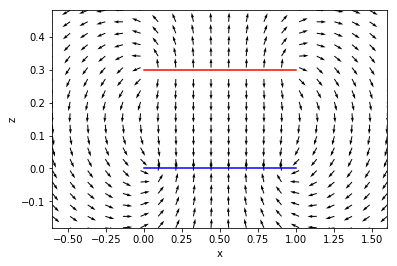

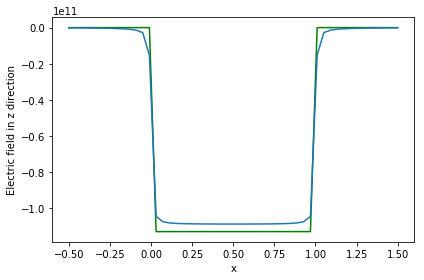

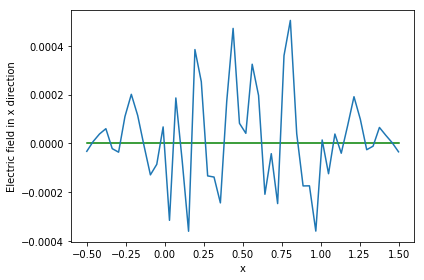

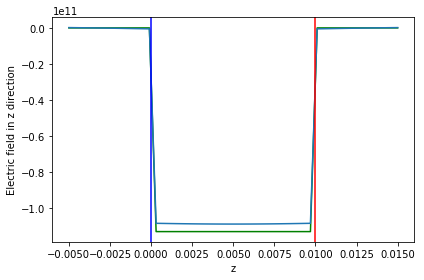

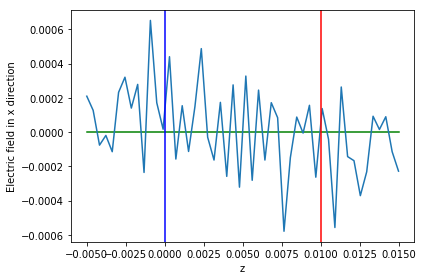

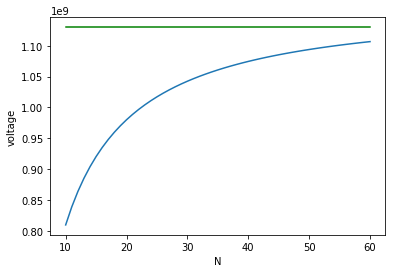

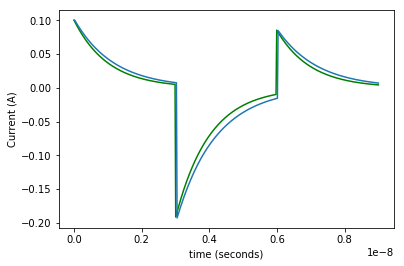

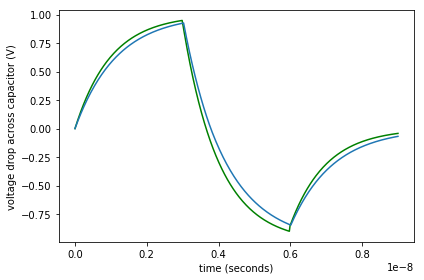

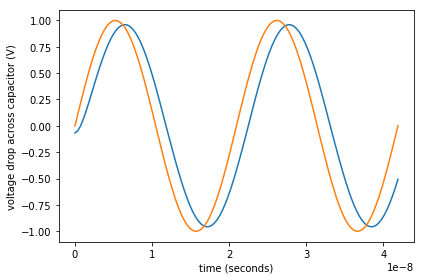

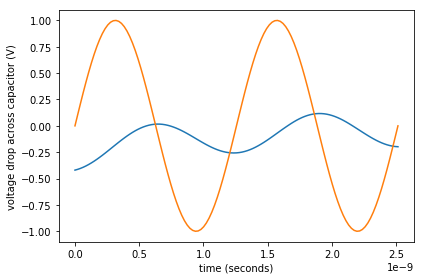

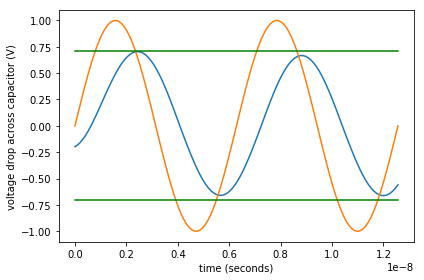

In [4]:
'''
Here we have two driver functions, the first for generating plots pertaining to the capacitor in itself
(mostly electric fields)
and the second generating plots for the RC-series circuit.
'''    
    
    
    
    
def SimulateCapacitor(saveplots=False, N=100):
    '''
    Creates electric field plots and converging voltage plot used in report.
    '''
    plotname=""
    # Electric field plots
    
    d=0.01
    Nx=N
    Ny=N
    xlength=1; ylength=1
    loc=np.zeros(3)
    
    
    if (saveplots):
        plotname="C1vectorfield"
    '''
    For plotting vector field we use only 20 by 20 grid since begin more accurate
    isn't necessary for this plot. We just want to see that the direction is behaving.
    '''
    cap1=Capacitor(separation=0.3, initialCharge=1, xlength=xlength, ylength=ylength, Nx=20, Ny=20)
    cap1.VFPlotElectricField(20,20, plotname)
        
    
    cap=Capacitor(separation=d, initialCharge=1, xlength=xlength, ylength=ylength, Nx=Nx, Ny=Ny, location=loc)


    if saveplots:
        plotname="C31Ezvxfinal"
    cap.PlotElectricField(axis=X, N=50, plotname=plotname, direction=zhat)

    if saveplots:
        plotname="C41Exvxfinal"
    cap.PlotElectricField(axis=X, N=50, plotname=plotname, direction=xhat)    

    if saveplots:
        plotname="C51Ezvzfinal"
    cap.PlotElectricField(axis=Z, N=50, plotname=plotname, direction=zhat)  


    if (saveplots):
        plotname="C71Exvzfinal"
    cap.PlotElectricField(axis=Z, N=50, plotname=plotname, direction=xhat)


    

        

def VoltageConverge(Nmin,Nmax,Nsteps,save=False):
    '''
    voltage converging to correct value.
    This one takes ages.
    '''
    
    d=0.01
    xlength=1; ylength=1
    
    voltages = np.zeros(Nmax+1-Nmin)
    Nlist = [N for N in range(Nmin, Nmax+1)]
    for N in Nlist:
        cap = Capacitor(separation=d, initialCharge=1, xlength=xlength, ylength=ylength, Nx=N, Ny=N)
        voltages[N-Nmin] = cap.CalculateVoltageDrop(Nsteps=Nsteps)
    plt.figure()
    plt.plot(Nlist, voltages)
    plt.xlabel("N")
    plt.ylabel("voltage")
    plt.plot(Nlist, [cap.Q/cap.C] * len(Nlist),'g')
    if (save):
        plt.savefig("convergefinal")



   

        
def PowerCircuit(save=False, N=30, Nsteps=20):
    plotname=""
    plotname2=""
    '''
    specs for capacitor and ideal resistor used in all circuit simulations included in report.
    '''
    R=10
    d=885e-6
    xlength=0.1
    ylength=0.1
    resistor = Resistor(R)
    Q0=0
    cap= Capacitor(xlength=xlength,ylength=ylength,separation=d, initialCharge=Q0, Nx=N, Ny=N, Nsteps=Nsteps)
    
    
    # Response to DC voltages input switched to +1V, then -1V, then 0.
    if save:
        plotname="Cap_DCresponse_currentfinal"
        plotname2="Cap_DCresponse_voltagefinal"
    Vs=1
    tau=R*cap.C
    dt=0.02*tau
    tmax=9*tau
    circuit = Series_RC_Circuit(Vs, resistor, cap, [-1,0], [3*tau,6*tau])
    circuit.SimulateResponse(tmax,dt)
    circuit.PlotCurrent(plotname, plotIdealDC=True)
    circuit.PlotVoltage(plotname2, plotIdealDC=True)
    #print(t[19],iHist[19])

    
    
    
    
    # response to sinusoidal input with varying frequency 
    if save:
        plotname="LPlowfreqfinal"
    wc=1/(R*cap.C)
    tau=cap.C*R

    Amp=1
    w=0.3*wc
    T=2*np.pi/w #period
    tmax = 2*T
    dt = T/60
    Vs = lambda t: Amp*np.sin(w*t)
    circuit = Series_RC_Circuit(Vs, resistor, cap)
    circuit.SimulateResponse(tmax, dt)
    circuit.PlotVoltage(plotname)
    plt.show()

    
    
    
    if save:
        plotname="LPhighfreqfinal"
    w=5*wc
    T=2*np.pi/w #period
    tmax = 2*T
    dt = T/60
    Vs = lambda t: Amp*np.sin(w*t)
    circuit = Series_RC_Circuit(Vs, resistor, cap)
    circuit.SimulateResponse(tmax, dt)
    circuit.PlotVoltage(plotname)

    plt.show()
    
    
    
    
    if save:
        plotname="LPcutofffinal"
    w=wc
    T=2*np.pi/w #period
    tmax = 2*T
    dt = T/60
    Vs = lambda t: Amp*np.sin(w*t)
    circuit = Series_RC_Circuit(Vs, resistor, cap)
    circuit.SimulateResponse(tmax, dt)
    circuit.PlotVoltage(plotname, plotCutoffAmplitude=True)

    plt.show()


    
    
'''
A lot of the parameters being passed to the functions making the plots have been toned down so 
that it doesn't take as long. The three lines commented out below generate the plots in the report,
while the lines not commented out generate less accurate versions that won't take as long.

They still take a while though
''' 

#SimulateCapacitor(N=300)
#VoltageConverge(Nmin=10,Nmax=80,Nsteps=40)
#PowerCircuit(N=50, Nsteps=40) 



SimulateCapacitor(N=80)
VoltageConverge(Nmin=10,Nmax=60,Nsteps=30)
PowerCircuit(N=20, Nsteps=10)   
    
    
      


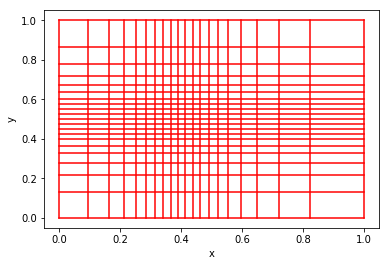

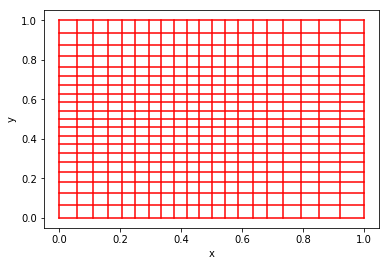

In [35]:
import numpy as np
import matplotlib.pyplot as plt


def DrawGrid(N, loc, plotname=''):
    """
    Draws the grid that a capacitor plate at z=0 is broken up into when calculating electric field at loc
    """
    d=0.1
    xmax=1; ymax=1
    cap = Capacitor(separation=d, initialCharge=-1, xlength=xmax, ylength=ymax, Nx=N, Ny=N)
    zdash=0
    X_arr=cap.GetXY(X,loc,zdash)
    Y_arr=cap.GetXY(Y,loc,zdash)
    
    plt.figure()
    plt.xlabel('x')
    plt.ylabel('y')
    for i in range(N+1):
        plt.plot(N*[X_arr[i]], np.linspace(0,ymax,N), color='red')
    for j in range(N+1):
        plt.plot(np.linspace(0,xmax,N),N*[Y_arr[j]], color='red')
    if (plotname):
        plt.savefig(plotname)

        
DrawGrid(20, np.array([0.4,0.5,0.2]))
DrawGrid(20, np.array([0.4,0.5,0.6]))
    
    